<a href="https://www.kaggle.com/code/peremartramanonellas/guide-tweet-analysis-with-logistic-regression?scriptVersionId=106057672" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
    horizontal-align: middle;
}
h1 {
    text-align: center;
    background-color: 57FEFF;
    padding: 10px;
    margin: 0;
    font-family: monospace;
    color:Gainsboro;
    border-radius: 10px
}

h2 {
    text-align: center;
    background-color: 57FEFF;
    padding: 10px;
    margin: 0;
    font-family: monospace;
    color:Gainsboro;
    border-radius: 10px
}

h3 {
    text-align: center;
    background-color: B1FFFF;
    padding: 10px;
    margin: 0;
    font-family: monospace;
    color:Gainsboro;
    border-radius: 10px
}


body, p {
    font-family: monospace;
    font-size: 15px;
    color: charcoal;
}
div {
    font-size: 14px;
    margin: 0;

}

h4 {
    padding: 0px;
    margin: 0;
    font-family: monospace;
    color: purple;
}
</style>
""")

# A solution to Disaster Tweets using a simple logistic regression. 

In this notebook we are going to solve the Disaster Tweets Kaggle competition writing our **OWN Sigmoid and gradient_descent FUNCTIONS** without using TensorFlow or SKLearn, despite it, we achieve a nice result in the leaderboard. 

One important part is how to trasform the tweets from something like: 
- **'@AmirKingKhan you would have been annihilated so you might as well thank @FloydMayweather'**

to: 
- **['would', 'annihil', 'might', 'well', 'thank']**

To achieve this it's necessary to do the next transformations: 

- Remove Marks: Remove punctuactions, and symbols. 
- Tokenize the sentence: Get all words, we are going to use *TweetTokenizer* from the *NLTK* library that have some intelligence adapted to tweets. 
- Remove Stop Words: Downloading the english lybrary *stopwords* from NLTK. We remove a lot of words from the tweets. In the sample above we removed: *you, have, been, as, and so*.
- Stem words: Using the *PorterStem* lybrary from *NLTK*. We tranform words to their stem. As you can see in the sample abobe *annihilation* has been tranformed into *annihil*. 

With the twets transformed is time to create a dictionary containing how many times each word appears in both categories (disaster and non disaster tweets). 


| Word | Disaster | No Disaster |
| :- | :-: | :-: |
| Ambulance | 40 | 5
| Crash | 50 | 25
| Flight | 10 | 50
| ... | ... | ...

We can use this table, to give a punctuation to the tweets and using the logistic regression decide in wich category classify the tweet. 


In [ ]:
#Import libraries

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

#Natural Language Toolkit
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer

import re
import string

# Load the Data

In [ ]:
train = pd.read_csv("../input/nlp-getting-started/train.csv")
test = pd.read_csv("../input/nlp-getting-started/test.csv")
train.head()

We are only going to use the *text* and *target* column, I will remove the rest of the columns in the train & test dataframe. 

In [ ]:
train.drop(['id','keyword', 'location'], axis = 1, inplace=True)
train.head()

In [ ]:
test.drop(['keyword', 'location'], axis = 1, inplace=True)
test.head()

## check number of tweets in each category

In [ ]:
#The Dataset is more or less balanced, we have enough tweeats in both categories. 
calm, disaster = train['target'].value_counts()
calm, disaster

In [ ]:
fig = plt.figure(figsize=(5,5))
labels = 'Calm', 'Disaster'
sizes = [calm, disaster]
plt.pie(sizes, labels=labels, autopct='%0.0f%%',
        shadow=True, startangle=90)
plt.axis('equal')
plt.show()

## Transform the tweets

### functions to transform the text

In [ ]:
#Load the library of stopwords from NLTK (Natural Language Toolkit). 
nltk.download('stopwords')

In [ ]:
#Remove hashtags, retweets and URL's symbols. 
def remove_marks(sentence):
    sentence_r = re.sub(r'^RT[\s]+', '', sentence)
    sentence_r = re.sub(r'https?://[^\s\n\r]+', '', sentence_r)
    sentence_r = re.sub(r'#', '', sentence_r)
    
    return sentence_r

In [ ]:
#Transfom the sentence in a list of words. 
TOKENIZER = TweetTokenizer(preserve_case=False, strip_handles=True, 
                              reduce_len=True)

def tokenize(sentence):     
    sentence_tokens = TOKENIZER.tokenize(sentence)
    return sentence_tokens

In [ ]:
#Remove StopWords and punctuations. 
STOPWORDS = stopwords.words('english')
def remove_stop_words(sentence_tokenized): 
    no_stop_words = []
    for word in sentence_tokenized:
        if ((word not in STOPWORDS) and (word not in string.punctuation)): 
            no_stop_words.append(word)
    return no_stop_words

In [ ]:
#Convert the words in their stem. 
STEMMER = PorterStemmer()
def stem_words(list_words):
    stemmed = []
    for word in list_words:
        stem_word = STEMMER.stem(word)
        stemmed.append(stem_word)
    return stemmed

In [ ]:
#this is the function that we are going to call to transform each tweet. 
def prepare_sentence(sentence):
    sentence_nomarks = remove_marks(sentence)
    sentence_tokenized = tokenize(sentence_nomarks)
    sentence_ready = remove_stop_words(sentence_tokenized)
    words_stemmed = stem_words(sentence_ready)
    return words_stemmed

In [ ]:
#testing with one tweet
tweet = train['text'][333]
tweet

In [ ]:
tweet_ready = prepare_sentence(tweet)
print(tweet_ready)

### Convert All Tweets

Just with a simple line of code we apply the function *prepare_sentence* to each tweet in the *train* DataFrame. 

In [ ]:
train['text'] = train.apply(lambda row : prepare_sentence(row['text']), axis=1)
train.head()

### Create the word dictionary

In [ ]:
#We recibe the sentences and the label for each one. 
#Create a dictionary where the key is the word and the label. 
#We create the key, look for it in the dictory and get the value incremented by 1. 
def count_words(sentences, ys):
    freqs = {}
    for y, sentence in zip(ys, sentences):
        for word in sentence:
            key = (word, y)
            freqs[key] = freqs.get(key, 0) +1 
    return freqs 

In [ ]:
#The first 10 elements in the dict
word_dict = count_words(train['text'], train['target'])
for i in range(10):
    item = word_dict.popitem()
    print (item)

In [ ]:
#the word *fire* appears 272 times in disater tweets and only 90 in no disaster
print (word_dict.get(('fire', 1)))
print (word_dict.get(('fire', 0)))

# Create the Model

The sigmoid function is really simple. Is used to give us a number between 0 and 1. And with this number decide in wich category we can categorize our tweet. 
In our case if is greater that 0.5 (closer to 1) the tweet is clasified as a Disaster. But if is under 0.5 is classified as a no Disaster. 

This function is used in the *gradient_descent* to classify the tweet and calculate the cost function and modify the *theta*. The *theta* is nothing more that an vector containing the line to divide the values. Values over the line are classified as Disaster and under as Non Disaster. 

In the gradient_descent functio we are continusly calculating the sigmoid, after that the loss values, and after that the theta. 


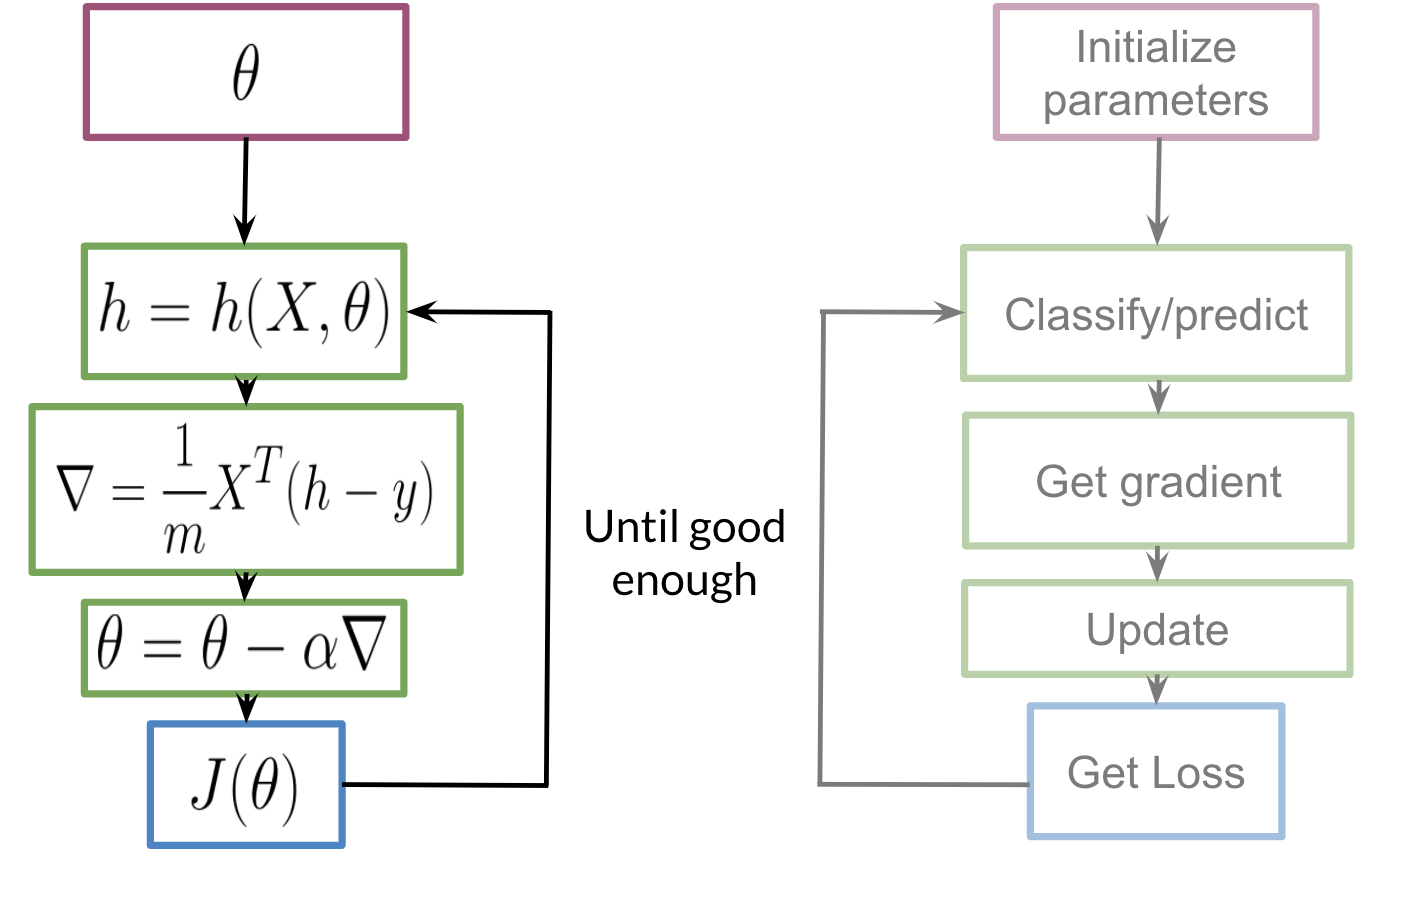

In [ ]:
def sigmoid(z): 
    h = 1 / ( 1 + np.exp(-z))
    return h

In [ ]:
#Here is where the theta is adapting in each iteration. 
#We recieve the features, and the labels and an initial theta. 

def gradient_descent(x, y, theta = np.zeros((3, 1)), alpha=1e-9, num_iters=1500):
    m = len(x)
    
    for i in range(0, num_iters):
        
        # get z, the dot product of x and theta
        z = x.dot(theta)
        #print (z)
        
        # get the sigmoid of z
        h = sigmoid(z)
        #print(h)
        
        # calculate the cost function
        J = -1./m * (np.dot(y.T, np.log(h)) + np.dot((1-y).T, np.log(1-h)))

        # update the weights theta
        theta = theta - (alpha/m) * np.dot(x.T, (h-y))

    J = float(J)
    return J, theta

## Obtain features & Train the model

In [ ]:
#Obtain the features of the tweets. 
#A feature is just an array of thre values composed by the bias
#The number of times that their words apeears in the list of Disater words. 
#he number of times that their words apeears in the list of no Disater words. 
def extract_features(word_sentence):
    x = np.zeros((1, 3)) 
    x[0, 0] = 1.0
    for word in word_sentence: 
        x[0, 1] += word_dict.get((word, 1), 0)
        
        x[0, 2] += word_dict.get((word, 0), 0)
    assert(x.shape==(1, 3))
    return x

In [ ]:
#Here we can see the features for one of the tweets. 
print('--------Words of tweet:')
print(train['text'][0])
print('--------Features:')
test_x = extract_features(train['text'][0])
test_x

In [ ]:
#Store in X all the tweet's features
X = np.zeros((len(train), 3))

for i in range(len(train)):
    X[i, :] = extract_features(train['text'][i])

X    

In [ ]:
#store in y the labels. 
y = train['target'].values.reshape(len(train),1)
y.shape

In [ ]:
#Train the model
#The first theta is just an array of 0's 
#if you want to improve the results just try to increase the num_iters 
J, THETA = gradient_descent(X, y, np.zeros((3, 1)), num_iters=10000)

In [ ]:
#J is the loss, as much closer to 0 the better. 
print(f"The cost after training is {J:.8f}.")
print(f"The resulting vector of weights is {[round(t, 8) for t in np.squeeze(THETA)]}")

### Predict sentiment & send results

In [ ]:
#We recieve a sentence / tweet and use *prepare_sentence* to get the words
#with extract_features we obtain the array with the features. 
#we can call sigmoid with the theta calculated in the training. 
#if the resuls is 0.5 or greater is a disaster tweet. 
def predict_sentiment(sentence):
    sentence_p = prepare_sentence(sentence)
    x=extract_features(sentence_p)
    
    y_pred = sigmoid(np.dot(x, THETA))
    
    return y_pred[0]

In [ ]:
#Just try with one sentence
predict_sentiment("Big earthquake")

In [ ]:
#Now we can try with different sentences. 
#it seems that it works fine with our samples. 
for sentence in ['all is good', 'We are under attack, and kidnapped', 'No one is here', 'Dead people and ambulance']:
    print( '%s -> %f' % (sentence, predict_sentiment(sentence))) 

In [ ]:
#Ok, now try with the first 10 tweets in the test DataFrame. 
for sentence in test['text'][:10]:
    print( '%s -> %f' % (sentence, predict_sentiment(sentence))) 

Checking the samples and the first 10 sentences in the DataFrame it seem's that we are able to predict when a tweet is indicating a disaster. 

Maybe the model is never so sure, with the sigmoid function returning always a number around 0.5. 

In [ ]:
results = []
for i in range(len(test)):
   results.append(np.int_(predict_sentiment(test['text'][i]).round()[0]))

In [ ]:
submission = pd.DataFrame({'id':test['id'].to_list(), 'target':results})
submission

In [ ]:
submission.to_csv('./submission.csv', index=False)

# Inspirations

The Main inspiration is the course: "NLP Specialization" from deeplearning.ai in coursera where I'm enrolled. 
https://www.deeplearning.ai/courses/natural-language-processing-specialization/

But I foud, too,  really nice information in the next articles: 
https://machinelearningmastery.com/a-gentle-introduction-to-sigmoid-function/

https://towardsdatascience.com/machine-leaning-cost-function-and-gradient-descend-75821535b2ef

As I'm doing the course my intention is continue this work publishing more NLP notebooks with different techniques adapted to Kaggle Datasets &  Competitions. If you want to be informed considere follow me :-) 

Plase if you liked the notebook, considere to **upvote** I will be really happy, and it encourage a lot to continue publishing.

Fel free to use it and fork at your convenience, if you have any doubt don't hesitate to use the comments section.  